# Introduction
El notebook de este TFM posee la siguiente estructura, detallada a continuación para su comprensión:
- 1. Import Library. Importaciones de Librerías
- 2. Import XML. Contiene las funciones necesarias para la lectura del fichero fuente XML de Orphadata, y, a partir de ahí, poder trabajar con los datos.
- 3. Exploratory Data Analysis (EDA) & Feature Engineering functions. Funciones asociadas a la Exploración de los datos, limpieza y preparación de los mismos. Contienen la funciones eda_data (más enfocada a "limpieza") y selection_data_by_frecuency (donde filtramos por la frecuencia de aparición de un síntoma en una enfermedad concreta).
- 4. DATA/MATRIX functions for recommender. Funciones asociadas al Experimento en las que se generan las matrices y listados necesarios para trabajar con un Sistema Recomendador. Contiene las siguientes funciones: 
        - generate_data_scoring, la cual se encarga generar una matriz de asociación entre un síntoma y una enfermedad
        (de acuerdo a la existecia/aparición del síntoma en la enfermedad), dando una puntación (en la casilla 
        correspondiente de la matriz) a la alineada a la frecuencia estadística de dicha aparecición (muy frecuente, 
        frecuente,....).
        - generate_data_recommendations, la cual se encarga de calcular dos matrices de trabajo .
        La primera de similitud entre los síntomas, y la segunda, que guarda en CSV, la de recomendaciones.
        Esta última de recomendación será cargada en el momento de calcular una recomendación de enfermedad 
        dado un síntoma.  Se trabajará con sqlite3 para guardar la matriz de recomendación, y no tener que calcularla 
        cada vez que queramos hacer una recomendación
        - generate_data_enfermedades, la cual genera un listado con todas las enfermedades para trabajar con él
        - generate_data_sintomas, la cual genera un listado con todas los síntomas para trabajar con él

Hasta este punto hablamos de la fase de procesamiento de información, la cual es identificada en el IDE Kedro (Visual Studio) como  pipeline de data_processing.

- 5. Recomendation functions. Funciones asociadas al Experimento en las que se realizan llamadas a los recomendadores trabajados. Contiene las siguientes funciones: 
        - recommendation_collaborative_filtering_user_based. Función que usa User Based de Collaborative Filtering
        para obtener una recomendación.
        - recommendation_similitud_by_pearson: Función que usa Correlación de Pearson para obtener una recomendación. 
        Recibe un Síntoma concreto y devuelve un listado de X enfermedades recomendadas (por scoring de mayor a 
        menor).
   
     La recomendación por pearson, la implementamos para ver resultados, comparar ambos algoritmos y verificar que los scorings son similares.


Hasta este punto hemos trabajado con las funciones para lanzar recomendaciones. Éstas están incluidas en el pipeline de data_science en el ID Kedro (Visual Studio)

- 6. Notebook Main: Common Tasks: Es el MAIN principal del notebook. Contiene las llamadas a las diferentes funciones definidas en el notebook para la obtención de los resultados. 




(*) Antes de comenzar con las librerías, tal vez le sea necesario instalar alguna de ellas. Es el caso ydata-profiling. Se adjunta el código para realizar dicha instalación. Utilicese si alguno de los import no le es reconocido y debe instalar, con pip, la librería en cuestión.



In [ ]:
!pip install ydata-profiling

# 1. Import Library
Se importan todas las librerías necesarias para trabajar en el presente Notebook para los dos experimentos que contiene

In [1]:
import xmltodict
import pandas as pd
import numpy as np
import sqlite3
import sklearn.metrics
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

# 2. Import XML

_limpia_nombre: Función privada, que usa import_enfermedades_xml, para eliminar carácteres innecesarios en los nombres encontrados en el XML fuente (para enfermedades y frecuencias) 

In [3]:
def _limpia_nombre (cadena):
    
    cadena_str= str(cadena)
    cadena_str=cadena_str[26:]
    cadena_str = cadena_str.replace('}', '',1)
    cadena_str = cadena_str.replace('\'','')
    
    return cadena_str

import_enfermedades_xml: Función que extrae a un dataframe los datos de Enfermedades-Síntomas-Frecuencias del XML de Orphadata  (almacenado en una ruta concreta). Se encarga de coger el XML y cargar la información de enfermedades-sintomas-frecuencias.
Es llamada únicamente al principio para trabajar, pues luego se continua con dataframes y csvs

In [4]:
def import_enfermedades_xml (path):
    xml=open(path, encoding='ISO-8859-1')
    xmldict = xmltodict.parse(xml.read())
    df_enfermedades = pd.DataFrame()
    lista_enfer_sinto_prob=[]
    first_tree=xmldict["JDBOR"]["HPODisorderSetStatusList"]["HPODisorderSetStatus"]
    id=0
    for nodo in xmldict["JDBOR"]["HPODisorderSetStatusList"]["HPODisorderSetStatus"]:
     
        enfermedad=_limpia_nombre(nodo["Disorder"]["Name"])
        sec_tree= nodo["Disorder"]["HPODisorderAssociationList"]
        if (len(sec_tree)==2):
            tam_sintomas=len(sec_tree["HPODisorderAssociation"])
            i=0
            registro_enfer_sinto_prob=[]
            while (i<tam_sintomas):
                registro_enfer_sinto_prob.append(id)
                registro_enfer_sinto_prob.append(enfermedad)
                registro_enfer_sinto_prob.append(sec_tree["HPODisorderAssociation"][i]["HPO"]["HPOTerm"])
                frecuencia=_limpia_nombre (sec_tree["HPODisorderAssociation"][i]["HPOFrequency"]["Name"])
                registro_enfer_sinto_prob.append(frecuencia)
                lista_enfer_sinto_prob.append (registro_enfer_sinto_prob)
                registro_enfer_sinto_prob=[]
                i=i+1
        id=id+1
    df_enfermedades = pd.DataFrame(lista_enfer_sinto_prob)
    df_enfermedades = df_enfermedades.rename(columns={0:'Id_Enfermedad',1:'Enfermedad', 2:'Sintoma', 3:"Frecuencia"})
    
    return df_enfermedades        

# 3. Exploratory Data Analysis (EDA) & Feature Engineering functions

eda_data: Función que dado un dataframe de entrada, aplica Exploratory Data Analysis. En concreto: elimina registros duplicados, los nulos, y los registros que contienen síntomas que sólo aparecen menos de 50 veces en nuestra muestra

In [5]:
def eda_data(data): 
    
    data=data.drop_duplicates()
    data=data.dropna()
    vc = data["Sintoma"].value_counts()
    vector=vc[vc < 50].index
    for a in vector:
        indexNames = data [ data["Sintoma"] == a ].index
        for b in indexNames:
            data.drop(b , inplace=True, axis=0)
    
    return data


selection_data_by_frecuency: Función que dado un dataframe de entrada, se queda con los registros de Enfermedad-Sintoma-Frecuencia que tengan una frecuencia "Muy frecuente", "Frecuente", "Obligatorio" y "Ocasional". Elimina pues los registros con frecuencia Muy poco frecuente y Excluyente.

In [7]:
def selection_data_by_frecuency(data):
    
   
    data=data[(data['Frecuencia']=="Muy frecuente (99-80%)") |
              (data['Frecuencia']=="Frecuente (79-30%)") |
              (data['Frecuencia']=="Obligatorio (100%)") |
              (data['Frecuencia']=="Ocasional (29-5%)") |
              (data['Frecuencia']=="Muy poco frecuente (4-1%)")
              
             ]
        
    return data


# 4. DATA/MATRIX functions  for recommender

_rename_col: Función privada que, dado un dataframe con un conjunto de columnas, modifica el nombre de dichas columnas para poder trabajar con su Id, en lugar de literales.
Es usada por la función generate_data_scoring para la construcción de la matriz de scoring




In [8]:
def _rename_col(df):
    
    df.rename(columns={'Sintoma':'Enfermedades'},
               inplace=True)
    columnas=len(df.columns)
    i=0
    while (i<columnas):
        df = df.rename(columns={df.columns[i]:i})
        i=i+1
        
        
    return df


generate_data_scoring: Función que dado un dataframe de entrada (con todas los registros existentes entre enfermedades, sus síntomas y la frecuencia de aparición), genera una matriz de enfermedades x sintomas, formada por valores únicamente en celdas donde un síntoma concreto (columna) aparezca en la enfermedad. El valor que tendrá dependerá de la frecuencia de aparición de dicho síntoma en la enfermedad (puntos) de tal forma que si es una frecuencia alta la aparición del síntoma en la enfermedad, tendrá más puntuación que una frecuencia más baja. 
Se persigue con esto disponer de una matriz de puntuaciones/ratings donde cruzamos todos los síntomas con todas las enfermedades, con un conjunto de puntuaciones. 
stas son las puntuaciones de acuerdo a la existencia de un síntoma en una enfermedad: "Muy frecuente"=3,
#"Frecuente"=2, "Obligatorio"=4 y "Ocasional"=1. El resto de celdas tendrá un valor 0

In [9]:
def generate_data_scoring (data, repeticiones):
    
    sintomas=data.iloc[:,1]
    sintomas_sin_repe=sintomas.drop_duplicates()
    sintomas_sin_repe=sintomas_sin_repe.sort_values(ascending
                              = True)
    df_scoring=pd.DataFrame(columns=sintomas_sin_repe)
  
    data_agrupado = (data.groupby("Enfermedad")
         .agg({"Sintoma": np.array, "Frecuencia": np.array})
         .reset_index()
         )
    
    z=0
    j=0
    while (z<repeticiones):
        i=0
        for a in data_agrupado["Enfermedad"]:

            lst = [0] * ((len(sintomas_sin_repe)))
           
            df_scoring.loc[len(df_scoring)] = lst    
            pos=0
            for b in data_agrupado["Sintoma"][i]:
               
                frecuencia=data_agrupado["Frecuencia"][i][pos]
  
                if (frecuencia=="Muy frecuente (99-80%)"):
                        valor_entero=4
                elif (frecuencia=="Frecuente (79-30%)"):
                        valor_entero=3
                elif (frecuencia=="Obligatorio (100%)"):
                    valor_entero=5
                elif (frecuencia=="Ocasional (29-5%)"):
                    valor_entero=2
                elif (frecuencia=="Muy poco frecuente (4-1%)"):
                    valor_entero=1
                    
                df_scoring[b][j]=valor_entero
               
                pos=pos+1
            j=j+1
            i=i+1
        z=z+1
    df_scoring=_rename_col(df_scoring)
    df_scoring=df_scoring.transpose()
    
    return df_scoring


generate_data_recommendations: Se encarga de calcular dos matrices de trabajo .La primera de similitud entre los síntomas, y la segunda, que guarda en CSV, la de recomendaciones. Esta última de recomendación será cargada en el momento de calcular una recomendación de enfermedad dado un síntoma.
En este experimento, con el objetivo de testear la librería sqlite3 (a parte de guardar en CSV), vamos a guardar la matriz de recomendación en una BBDD, con el objetivo de que esté disponible cuando se quiera hacer un cálculo de recomendación, sin necesidad de calcular la matriz cada vez que queramos trabajar en las recomendaciones.
Esta función es comentada con más detalle para su entendimiento

In [10]:
def generate_data_recommendations (ratings_matrix):
    #Recibimos la matriz "ratings_matrix" que está compuesta por el cruce entre todos los síntomas y todos las
    #enfermedades; y que tiene los valores 0 (cuando no hay relación) y 1,2,3 y 4 en función de la frecuencia
    #de releación entre el síntoma y la enfermedad. Por ejemplo, si la frecuencia es "muy frecuente", vendrá
    #con un 4 en la celda de relación entre el síntoma y la enfermedad.
    
    
    
    #Ahora calculamos la matriz de la similitud entre síntomas, utilizando la función cosine_similarity (distancia
    #del coseno (vectores))
   
    sim_matrix= sklearn.metrics.pairwise.cosine_similarity(ratings_matrix)
    #Ya tenemos la matriz de similitudes. 
    
  
    #Ahora ya podemos calcular las recomendaciones. Podemos predecir las enfermedades recomendadas a partir 
    #de una matriz calculada en donde hay relación entre cada enfermedad y síntoma (con un scoring)
  
    #Por eso usamos "ratings_matrix" que tiene las "puntuaciones" entre síntoma y enfermedad y "sim_matrix" que
    #contiene la similitud entre síntomas.
    #Cada rating se multiplica por el factor de similitud del síntoma que dio el rating. 
    #La predicción final por enfermedad será igual a la suma del peso de los ratings dividido por la “suma ponderada”.
    recom_matrix = sim_matrix.dot(ratings_matrix) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
    # Producto de Matriz de similitud (sim_matrix) con la matrix inicial (ratings_matrix)
    #/ (sumatoria de cada fila de ratings) con Transpuesta
    
    print ("matriz de similitudes entre síntomas")
    print (sim_matrix)
    print (sim_matrix.shape)
    print ("matriz de recomendaciones entre síntoma y enfermedades")
    print (recom_matrix)
    print (recom_matrix.shape)
    #Preparamos BBDD
    conn = sqlite3.connect('test_database')
    c = conn.cursor()
    #Hacemos transpose para guardar o dará error en "demasiadas columnas" (limitación de sqlite)
    recom_matrix=recom_matrix.transpose()
    df = pd.DataFrame(recom_matrix)
    df.to_sql('scorings_tfm_T', conn, if_exists='replace', index = False)
    
    #Ya tenemos guardada la matriz de recomendaciones para el uso que necesitemos en el momento de recomendar

    #No devolvemos nada. En el momento que se quiera usar la matriz, se cargará de BBDD
    

generate_data_enfermedades: Función que genera un CSV con todas las enfermedades registradas. Es una función
para luego trabajar de forma sencilla con el listado de enfermedades


In [11]:
def generate_data_enfermedades (data):
    data=data.groupby (["Enfermedad"]).count().reset_index()
    data=data.drop(["Sintoma","Frecuencia"], axis=1)
    df_Enfermedades=data.reset_index()
    return df_Enfermedades

generate_data_sintomas: Función que genera un CSV con todas los síntomas registradas. Es una función
para luego trabajar de forma sencilla con el listado de síntomas

In [12]:
def generate_data_sintomas (data):
    data=data.groupby (["Sintoma"]).count().reset_index()
    df_Sintomas=data.drop(["Enfermedad","Frecuencia"], axis=1)
    return df_Sintomas

# 5. Recomendation functions

_monta_listado: Función privada que dado un listado de recomendaciones (con scoring), el dataframe de enfermedades-sintomas-frecuencias, el listado de enfermedades y el listado de sintomas, muestra un listado ordenado para sacar una  clasificación visual de enfermedades encontradas con el síntoma, la frecuencia de aparición y su scoring.
Es usada tanto para el algortimo de recomendación user based como el de test de pearson

In [13]:
def _monta_listado (scoring_enfermedades,id_Sintoma,df_EnfeySinto_cleaned_select_no_id, df_Enfermedades, df_Sintomas):
    


    
    
    j=0
    enfermedades=[]
    while (j<len(scoring_enfermedades)):
        enfermedad=[]
        id_enfermedad=scoring_enfermedades["index"][j]
        scoring=scoring_enfermedades[id_Sintoma][j]
        
        enfermedad.append(id_enfermedad)
        
       
        enfermedad.append(df_Enfermedades[df_Enfermedades["index"]==id_enfermedad]["Enfermedad"].values[0])
   
        enfermedad.append(str(scoring))
        lista=df_EnfeySinto_cleaned_select_no_id[df_EnfeySinto_cleaned_select_no_id["Enfermedad"]==
                                   df_Enfermedades.loc[id_enfermedad][1]]
        lista=lista.reset_index()
        sintoma= df_Sintomas.loc[id_Sintoma].Sintoma
        enfermedad.append(sintoma)
        i=0
        while i<len(lista):
         
            if lista["Sintoma"][i]==sintoma:
                enfermedad.append(lista["Frecuencia"][i])
            
            i=i+1  
        j=j+1
        enfermedades.append(enfermedad)
        df_enfermedades=pd.DataFrame(enfermedades)
        
    return df_enfermedades




recommendation_collaborative_filtering_user_based: Función que usa User Based de Collaborative Filtering para obtener una recomendación. Recibe un Síntoma concreto y devuelve un listado de X enfermedades recomendadas (por scoring de mayor a menor). Necesita de forma auxiliar el dataframe de enfermedades-sintomas-frecuencias

In [14]:
def recommendation_collaborative_filtering_user_based(sintoma, elementos, df_EnfeySinto_cleaned_select_no_id):
 
     #Nos viene el Síntoma en la variable "sintoma" (ejemplo "Cough") y el número de elementos enfermedades
    #que queremos que nos recomiende con ese síntoma. 
    
    #Cogemos los DFs de síntomas y enfermedades
    df_sintomas=generate_data_sintomas (df_EnfeySinto_cleaned_select_no_id)
    df_enfermedades=generate_data_enfermedades(df_EnfeySinto_cleaned_select_no_id)

    #Sacamos el Id del Sintoma (al tener el texto)    
    id_sintoma = df_sintomas[df_sintomas['Sintoma'] == sintoma].index.values[0]
    
    
    #Necesitamos, como no, la matriz de recomendaciones. La habíamos guardado en BBDD, cargamos con SQlite
    conn = sqlite3.connect('test_database')
    c = conn.cursor()
    c.execute('''  SELECT * FROM scorings_tfm_T
          ''')

    #Obtenemos c.fetchall la matriz y montamos dataframe
    df_recomendaciones = pd.DataFrame(c.fetchall()) 
   
    #transpose porque hemos tenido que hacer transpose para guardar
    df_recomendaciones=df_recomendaciones.transpose()
    #ahora la convertimos en array numpy para operar (hacer argsort)
    df_recomendaciones=df_recomendaciones.to_numpy()
       
    
    

    
    #Con la matrix de recomendaciones (síntomas vs enfermedades) cogemos únicamente el vector de enfermedades
    #relacionadas con el síntoma "id_sintoma"
    #Pero ojo,    hemos cogido un vector de enfermedades ordenadas.
    enfermedades=df_recomendaciones.argsort()[id_sintoma]
    #
    vector_id_enfermedad_scoring=[]
    #Inicializamos nuestro vector TOTAL que tendrá las parejas de "enfermedad" /scoring de recomendación
    #(valor en la matriz recomendaciones)
    for i, enfermedad_id in enumerate(enfermedades[-elementos:]):  #Nos cogemos las x primeras enfermedades   
        #
        vector_enfermedades=[]
    #vamos cogiendo cada pareja de id enfermedad y el scoring de recomendación  (la pareja la montamos en un vector=)
        vector_enfermedades.append (enfermedad_id)
        vector_enfermedades.append (df_recomendaciones[id_sintoma][enfermedad_id])
       
       
        vector_id_enfermedad_scoring.append(vector_enfermedades)  #metemos la pareja en el vector TOTAL
      
    vector_id_enfermedad_scoring=pd.DataFrame(vector_id_enfermedad_scoring)
    #pasamos a data frame y luego montamos con la función interna "monta_listado" una visualización mejor.
    vector_id_enfermedad_scoring = vector_id_enfermedad_scoring.rename(columns={1:id_sintoma, 0:"index"})
    
    listado_para_visualizar=_monta_listado (vector_id_enfermedad_scoring,id_sintoma,
                                            df_EnfeySinto_cleaned_select_no_id,df_enfermedades, df_sintomas)
    listado_para_visualizar=listado_para_visualizar.rename(columns={0: "Id Enfermedad",1: "Enfermedad",
                                                                    2: "Scoring", 3: "Síntomas", 4: "Frecuencia"})
    listado_para_visualizar=listado_para_visualizar.sort_values("Scoring", ascending=False)
    listado_para_visualizar=listado_para_visualizar.reset_index()
    listado_para_visualizar.drop("index", axis=1, inplace=True)
  
    return listado_para_visualizar

recommendation_similitud_entre_usuarios_by_pearson: Función que usa Correlación de Pearson para obtener una recomendación. Recibe un Síntoma concreto y devuelve un listado de X enfermedades recomendadas (por scoring de mayor a menor).
Necesita de forma auxiliar el dataframe de enfermedades-sintomas-frecuencias, y la matriz de scoring para cálculos

In [15]:
def recommendation_by_pearson (df_scoring, sintoma,elementos,df_EnfeySinto_cleaned_select_no_id):
    
    df_sintomas=generate_data_sintomas (df_EnfeySinto_cleaned_select_no_id)
    df_enfermedades=generate_data_enfermedades(df_EnfeySinto_cleaned_select_no_id)
    id_sintoma = df_sintomas[df_sintomas['Sintoma'] == sintoma].index.values[0]

    
    
    df_transpuesta=df_scoring.transpose()
    correlaciones = df_transpuesta.corr(method='pearson')

    MediasUsers = df_transpuesta.mean(numeric_only=True,skipna=True)
    DesviacionesUsers = df_transpuesta.std(numeric_only=True,skipna=True)
    df_ValoracionesNorm = df_transpuesta[MediasUsers.index].sub(MediasUsers, axis='columns')

    df_ValoracionesNorm = df_ValoracionesNorm.div(DesviacionesUsers, axis='columns')

    Numerador = df_ValoracionesNorm.dot(correlaciones)
    Numerador.sort_values(0,ascending=False)
    Denominador = correlaciones.abs().sum()
    Cociente = Numerador.div(Denominador, axis='columns')

    Valoraciones = Cociente.mul(DesviacionesUsers,axis='columns').add(MediasUsers, axis='columns')

    a=Valoraciones[id_sintoma].sort_values(ascending=False).head(elementos)
    
    
    
    
    
    vector=pd.DataFrame(a)
    vector=vector.reset_index()
    listado_para_visualizar=_monta_listado (vector,id_sintoma, df_EnfeySinto_cleaned_select_no_id,
                                            df_enfermedades, df_sintomas)
    listado_para_visualizar=listado_para_visualizar.rename(columns={0: "Id Enfermedad", 1: "Enfermedad",
                                                                    2: "Scoring", 3: "Síntomas", 4: "Frecuencia"})
    listado_para_visualizar=listado_para_visualizar.sort_values("Scoring", ascending=False)
 
    return listado_para_visualizar

# 6. Notebook Main

## Common Tasks



Vayamos por pasos:

Se comienza con la lectura del fichero XML fuente de Orphadata, llamando a la función definida anteriormente

In [16]:
df_EnfeySinto=import_enfermedades_xml("../data/01_raw/enfermedades.xml")


A modo visual, vemos qué hemos obtenido de esta lectura, tanto a nivel de Enfermedades, como síntomas y frecuencias de aparición

In [17]:
print ("Datos de Lectura del XML Fuente Orphadata")
print ("Enfermedades: ", df_EnfeySinto["Enfermedad"].nunique())
print ("Sintomas: ", df_EnfeySinto["Sintoma"].nunique())
print ("Frecuencias: ", df_EnfeySinto["Frecuencia"].nunique())  

Datos de Lectura del XML Fuente Orphadata
Enfermedades:  4262
Sintomas:  8303
Frecuencias:  6


Este es el aspecto que tiene este Dataframe de Enfermedades, los síntomas que tiene, y la frecuencia de aparición. Utilizamos el Id_Enfermedad para visualizar que está cogiendo bien la agrupaciónd de enfermedades

In [18]:
df_EnfeySinto

,Id_Enfermedad,Enfermedad,Sintoma,Frecuencia
0,0,Enfermedad de Alexander,Macrocephaly,Muy frecuente (99-80%)
1,0,Enfermedad de Alexander,Intellectual disability,Muy frecuente (99-80%)
2,0,Enfermedad de Alexander,Seizure,Muy frecuente (99-80%)
3,0,Enfermedad de Alexander,Spasticity,Muy frecuente (99-80%)
4,0,Enfermedad de Alexander,Agenesis of corpus callosum,Muy frecuente (99-80%)
...,...,...,...,...
112684,4263,Nevo de cabello lanoso,Brachydactyly,Ocasional (29-5%)
112685,4263,Nevo de cabello lanoso,Widely-spaced incisors,Ocasional (29-5%)
112686,4263,Nevo de cabello lanoso,Persistent pupillary membrane,Ocasional (29-5%)
112687,4263,Nevo de cabello lanoso,Enlarged vestibular aqueduct,Ocasional (29-5%)


Ahora comenzamos a limpiar y ver si podemos mejorar los registros. Son muchos síntomas para menos enfermedades. Aplicamos la función eda_data para limpiar repetidos, nulos y quedarnos con los registros que contienen frecuencias que aparecen más de 50 veces en nuestra data

In [19]:
%%time
df_EnfeySinto_cleaned=eda_data(df_EnfeySinto)


CPU times: user 5min 49s, sys: 2.22 s, total: 5min 52s
Wall time: 5min 54s


Mejoramos notablemente al visualizar los síntomas. Hemos bajado. Vemos también el aspecto del dataframe

In [20]:
print ("Después de EDA")
print ("Enfermedades: ", df_EnfeySinto_cleaned["Enfermedad"].nunique())
print ("Sintomas: ", df_EnfeySinto_cleaned["Sintoma"].nunique())
print ("Frecuencias: ", df_EnfeySinto_cleaned["Frecuencia"].nunique())  

Después de EDA
Enfermedades:  4187
Sintomas:  483
Frecuencias:  6


In [21]:
df_EnfeySinto_cleaned


,Id_Enfermedad,Enfermedad,Sintoma,Frecuencia
0,0,Enfermedad de Alexander,Macrocephaly,Muy frecuente (99-80%)
1,0,Enfermedad de Alexander,Intellectual disability,Muy frecuente (99-80%)
2,0,Enfermedad de Alexander,Seizure,Muy frecuente (99-80%)
3,0,Enfermedad de Alexander,Spasticity,Muy frecuente (99-80%)
4,0,Enfermedad de Alexander,Agenesis of corpus callosum,Muy frecuente (99-80%)
...,...,...,...,...
112675,4262,Artrogriposis múltiple congénita miogénica aut...,Microcephaly,Excluyente (0%)
112676,4262,Artrogriposis múltiple congénita miogénica aut...,Polyhydramnios,Excluyente (0%)
112679,4263,Nevo de cabello lanoso,Fine hair,Muy frecuente (99-80%)
112684,4263,Nevo de cabello lanoso,Brachydactyly,Ocasional (29-5%)


Hay frecuencias que podemos obviar al no ver importante un síntoma por ejemplo que aparezca muy muy poco, aplicamos la función de selección por frecuencia, y vemos el aspecto del data

In [22]:
%%time
df_EnfeySinto_cleaned_select=selection_data_by_frecuency(df_EnfeySinto_cleaned)


CPU times: user 15.3 ms, sys: 944 µs, total: 16.2 ms
Wall time: 15.4 ms


In [23]:
df_EnfeySinto_cleaned_select

,Id_Enfermedad,Enfermedad,Sintoma,Frecuencia
0,0,Enfermedad de Alexander,Macrocephaly,Muy frecuente (99-80%)
1,0,Enfermedad de Alexander,Intellectual disability,Muy frecuente (99-80%)
2,0,Enfermedad de Alexander,Seizure,Muy frecuente (99-80%)
3,0,Enfermedad de Alexander,Spasticity,Muy frecuente (99-80%)
4,0,Enfermedad de Alexander,Agenesis of corpus callosum,Muy frecuente (99-80%)
...,...,...,...,...
112671,4262,Artrogriposis múltiple congénita miogénica aut...,Postnatal growth retardation,Ocasional (29-5%)
112672,4262,Artrogriposis múltiple congénita miogénica aut...,Gastrostomy tube feeding in infancy,Ocasional (29-5%)
112679,4263,Nevo de cabello lanoso,Fine hair,Muy frecuente (99-80%)
112684,4263,Nevo de cabello lanoso,Brachydactyly,Ocasional (29-5%)


In [24]:
  print ("Después de Selection")
  print ("Enfermedades: ", df_EnfeySinto_cleaned_select["Enfermedad"].nunique())
  print ("Sintomas: ", df_EnfeySinto_cleaned_select["Sintoma"].nunique())
  print ("Frecuencias: ", df_EnfeySinto_cleaned_select["Frecuencia"].nunique())  


Después de Selection
Enfermedades:  4182
Sintomas:  483
Frecuencias:  5


Por último, eliminamos la columna Id_Enfermedad, la cual estamos usando para que, en la visualización de los DF, chequeemos si las enfermedades se listan correctamente

In [25]:
df_EnfeySinto_cleaned_select_no_id=df_EnfeySinto_cleaned_select.drop("Id_Enfermedad", axis=1)
df_EnfeySinto_cleaned_select_no_id


,Enfermedad,Sintoma,Frecuencia
0,Enfermedad de Alexander,Macrocephaly,Muy frecuente (99-80%)
1,Enfermedad de Alexander,Intellectual disability,Muy frecuente (99-80%)
2,Enfermedad de Alexander,Seizure,Muy frecuente (99-80%)
3,Enfermedad de Alexander,Spasticity,Muy frecuente (99-80%)
4,Enfermedad de Alexander,Agenesis of corpus callosum,Muy frecuente (99-80%)
...,...,...,...
112671,Artrogriposis múltiple congénita miogénica aut...,Postnatal growth retardation,Ocasional (29-5%)
112672,Artrogriposis múltiple congénita miogénica aut...,Gastrostomy tube feeding in infancy,Ocasional (29-5%)
112679,Nevo de cabello lanoso,Fine hair,Muy frecuente (99-80%)
112684,Nevo de cabello lanoso,Brachydactyly,Ocasional (29-5%)


Ya hemos ejecutado las fases 1,2 y 3, con Importaciones de Librerías, Importación del XML (a CSV) y proceso EDA & Feature Engineering. Podemos comenzar a trabajar con funciones propias del recomendador (fases 4 y 5).

Es importante quedarnos con este dataframe : df_EnfeySinto_cleaned_select_no_id  pues será utilizado (de forma auxiliar) por los recomendadores (para obtener listado de síntomas, enfermedades y visualización de información)

Para empezar, usamos las funciones del apartado 4, y construimos las matrices de scoring, similitud y recomendación

## All matrices

### Datos Ratings Matrix

Para comenzar a trabajar con el recomendador, obtenemos la matriz de scoring

In [27]:
%%time
df_scoring=generate_data_scoring (df_EnfeySinto_cleaned_select_no_id, 1)
df_scoring


CPU times: user 7.44 s, sys: 246 ms, total: 7.69 s
Wall time: 7.76 s


,0,1,2,3,4,5,6,7,8,9,...,4172,4173,4174,4175,4176,4177,4178,4179,4180,4181
Sintoma,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
480,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


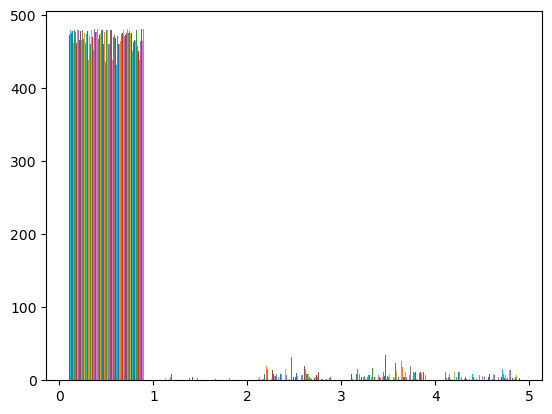

In [28]:
plt.hist(df_scoring,bins=5);

In [ ]:
profile = ProfileReport(df_scoring, title="Profiling Report")

In [ ]:
#profile

### Similitud y Recomendación matrix

Vamos a generar las matrices de similitud, y la de recomendación. La de recomendación la guardamos en BBDD para ser utilizada.
Hemos hecho un print sencillo para ver cómo son estas dos matrices.

In [29]:
%%time
generate_data_recommendations (df_scoring.values)

matriz de similitudes entre síntomas
[[1.         0.2449355  0.01663781 ... 0.         0.         0.02504897]
 [0.2449355  1.         0.10391733 ... 0.01159502 0.01987183 0.00695343]
 [0.01663781 0.10391733 1.         ... 0.         0.00449947 0.        ]
 ...
 [0.         0.01159502 0.         ... 1.         0.17446139 0.13463718]
 [0.         0.01987183 0.00449947 ... 0.17446139 1.         0.12193469]
 [0.02504897 0.00695343 0.         ... 0.13463718 0.12193469 1.        ]]
(483, 483)
matriz de recomendaciones entre síntoma y enfermedades
[[0.05116351 0.12306618 0.11172812 ... 0.24792723 0.02969554 0.        ]
 [0.02353888 0.12048031 0.08253929 ... 0.47169178 0.01931539 0.        ]
 [0.02978639 0.16072081 0.10968058 ... 0.3139235  0.02221663 0.00517687]
 ...
 [0.28992187 0.21377526 0.2565827  ... 0.01598651 0.03617126 0.00648785]
 [0.13268955 0.21740626 0.22460114 ... 0.02080431 0.05102426 0.0111105 ]
 [0.12992889 0.21391882 0.24074044 ... 0.02576662 0.03527477 0.01131042]]
(483, 418

Ya tenemos la matriz de recomendación, podemos comenzar a hacer recomendaciones.  Primero, para ver el comportamiento de los algoritmos, comenzamos con una llamada con un sólo síntoma

## Un sólo síntoma: Colaborative Filtering - User Based

Hacemos la llamada al recomendador que hemos desarrollado con User Based, indicamos un síntoma ("Cough"), y decimos que nos muestre los 10 elementos mejores (ranking de 10 enfermedades). Como hemos comentado usamos df_EnfeySinto_cleaned_select_no_id para uso auxiliar, pero necesario

In [30]:
list_recomendaciones_by_user_based=recommendation_collaborative_filtering_user_based(
    "Cough",10,df_EnfeySinto_cleaned_select_no_id)
list_recomendaciones_by_user_based

,Id Enfermedad,Enfermedad,Scoring,Síntomas,Frecuencia
0,1425,Granulomatosis con poliangeítis,1.1991365889396226,Cough,Frecuente (79-30%)
1,1193,Enfermedad de los legionarios,1.0537715928739704,Cough,Muy frecuente (99-80%)
2,1978,Neumonía necrotizante estafilocócica,0.960646295015468,Cough,Muy frecuente (99-80%)
3,2724,Síndrome de Hughes-Stovin,0.9355862377103205,Cough,Muy frecuente (99-80%)
4,1427,Gripe aviar,0.9207995169796739,Cough,Muy frecuente (99-80%)
5,1701,Linfoma de Hodgkin,0.8833659769402227,Cough,Frecuente (79-30%)
6,4164,Vasculitis urticarial hipocomplementémica,0.8826045218298191,Cough,Frecuente (79-30%)
7,4038,Tifus de las malezas,0.8756724218360147,Cough,Muy frecuente (99-80%)
8,1694,Linfangioleiomiomatosis,0.8689300994773601,Cough,Muy frecuente (99-80%)
9,1369,Fiebre hemorrágica con síndrome renal,0.8608008326347719,Cough,Ocasional (29-5%)


Ya tenemos un primer ranking, donde vemos la enfermedad, la frecuencia con la que el síntoma introducido aparece en dicha enfermedad, y el scoring que devuelve el algoritmo. 
Vamos a hacer una pequeña comprobación de que la información es consistente. Comprobamos cómo aparece (si aparece) un síntoma (el que hemos introducido) en una de las enfermedades devueltas en el ranking. Parece ok.

In [31]:
df_EnfeySinto_cleaned_select_no_id[(df_EnfeySinto_cleaned_select_no_id["Enfermedad"]=="Granulomatosis con poliangeítis") &
                     ((df_EnfeySinto_cleaned_select_no_id["Sintoma"]=="Cough") )]

,Enfermedad,Sintoma,Frecuencia
8239,Granulomatosis con poliangeítis,Cough,Frecuente (79-30%)


## Un sólo síntoma: Correlación de Pearson


El algoritmo User Based, es el algoritmo que usaremos para montar el proyecto en Visual studio y disponibilizar a nivel web vía streamlit. Pero, además de las métricas usadas, quiero ver otro algoritmo, y comparar qué devuelve, ver sus resultados...

Hacemos la llamada al recomendador que hemos desarrollado usando Correlación de Pearson (explicado en clase), indicamos un síntoma ("Cough"), y decimos que nos muestre los 10 elementos mejores (ranking de 10 enfermedades). Como hemos comentado usamos df_EnfeySinto_cleaned_select_no_id para uso auxiliar, pero necesario. Aquí usamos para el cálculo la matriz de scoring.

In [32]:
list_recomendaciones_by_pearson=recommendation_by_pearson(df_scoring,"Cough", 10,df_EnfeySinto_cleaned_select_no_id)
list_recomendaciones_by_pearson

,Id Enfermedad,Enfermedad,Scoring,Síntomas,Frecuencia
0,1425,Granulomatosis con poliangeítis,0.9506726923402106,Cough,Frecuente (79-30%)
1,1978,Neumonía necrotizante estafilocócica,0.8966942315368877,Cough,Muy frecuente (99-80%)
2,1193,Enfermedad de los legionarios,0.8722877194340616,Cough,Muy frecuente (99-80%)
3,2724,Síndrome de Hughes-Stovin,0.856628118651467,Cough,Muy frecuente (99-80%)
4,1211,Enfermedad por anticuerpos anti-membrana basal...,0.8102550948532303,Cough,Muy frecuente (99-80%)
5,4164,Vasculitis urticarial hipocomplementémica,0.776120413414476,Cough,Frecuente (79-30%)
6,216,Aspergilosis,0.7739843784201085,Cough,Muy frecuente (99-80%)
7,1694,Linfangioleiomiomatosis,0.7643655105118782,Cough,Muy frecuente (99-80%)
8,346,Blastoma pulmonar,0.7526337228198833,Cough,Muy frecuente (99-80%)
9,1427,Gripe aviar,0.7474967975300675,Cough,Muy frecuente (99-80%)


Perfecto!  vemos que las recomendaciones son bastantes similares, diferentes scorings y "bailan" en posición del ranking, pero parece que ambos algoritmos devuelven un ranking muy similar.

In [ ]:
#SUCIO DE AQUI EN ADELANTE...

In [ ]:
ratings = df_scoring.values
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

In [ ]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2, random_state=42)
print(ratings_train.shape)
print(ratings_test.shape)